# Credit Risk Modelling on the Loan Defaulter dataset

## Credit Card Default Data

### Description:
A simulated data set containing information on ten thousand customers. The aim here is to predict which customers will default on their credit card debt.

### Usage
Default

### Format
A data frame with 10000 observations on the following 4 variables.

*default:*
A factor with levels No and Yes indicating whether the customer defaulted on their debt

*student:*
A factor with levels No and Yes indicating whether the customer is a student

*balance:*
The average balance that the customer has remaining on their credit card after making their monthly payment

*income:*
Income of customer

### Source:
Simulated data

##### Importing the necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns 
color = sns.color_palette()
import sklearn.metrics as metrics
import warnings
warnings.filterwarnings("ignore")

##### Loading the dataset

In [2]:
data = pd.read_csv("Default.csv")

data.head()

,default,student,balance,income
0,No,No,729.53,44361.63
1,No,Yes,817.18,12106.13
2,No,No,1073.55,31767.14
3,No,No,529.25,35704.49
4,No,No,785.66,38463.50


In [3]:
# Lets check the shape of the dataset

data.shape

(10000, 4)

##### Exploratory Data Analysis

In [4]:
# Five number summary

data.describe()

,balance,income
count,10000.000000,10000.000000
mean,835.374877,33516.981852
std,483.714957,13336.639582
min,0.000000,771.970000
25%,481.732500,21340.460000
50%,823.635000,34552.645000
75%,1166.305000,43807.730000
max,2654.320000,73554.230000


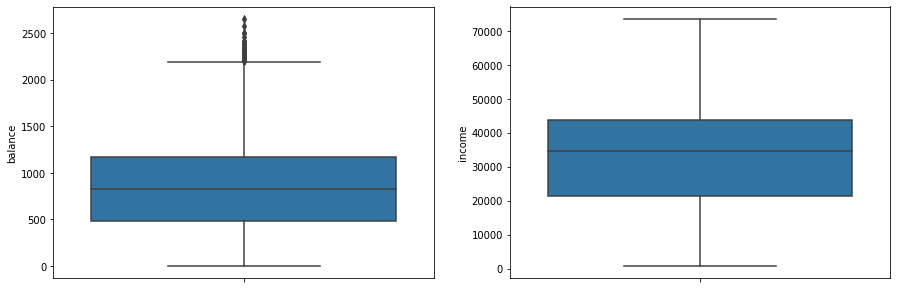

In [5]:
# Univariate Analysis: Balance and Income variable

plt.figure(figsize = (15,5))

# For balance
plt.subplot(1,2,1)
sns.boxplot(y = data.balance)

# For income
plt.subplot(1,2,2)
sns.boxplot(y = data.income)

plt.show();

We can see some amount of outliers with the balance varible. We need to find out of these how many are defaulters.

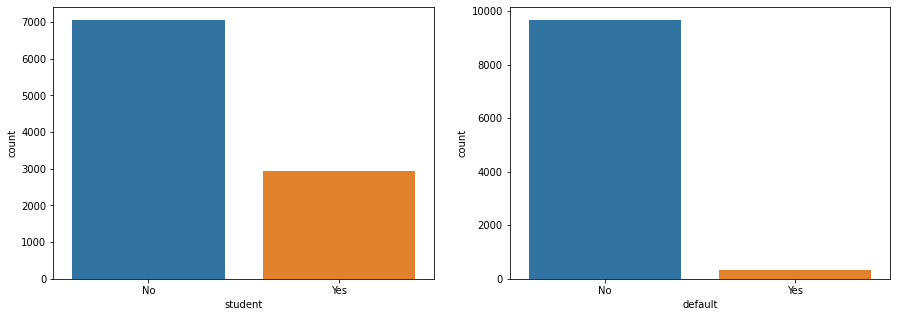

In [8]:
# Univariate Analysis on student and default variables

plt.figure(figsize = (15, 5))

# For student
plt.subplot(1,2,1)
sns.countplot(data.student)

# For default
plt.subplot(1,2,2)
sns.countplot(data.default)

plt.show()

We can see that out of total number of customers 3000 are students and 9600 are non defaulters whereas only 300 are defaulters (approx). Its an imbalanced dataset. 

In [9]:
# Lets check the accurate number of students in the dataset

data.student.value_counts()

No     7056
Yes    2944
Name: student, dtype: int64

In [10]:
# Lets check the accurate number of defaulters in the dataset

data.default.value_counts()

No     9667
Yes     333
Name: default, dtype: int64

In [11]:
# Lets check the proportion of default

data.default.value_counts(normalize = True)

No     0.9667
Yes    0.0333
Name: default, dtype: float64

We see that 3% of the customers are defaulters out of the total customers.

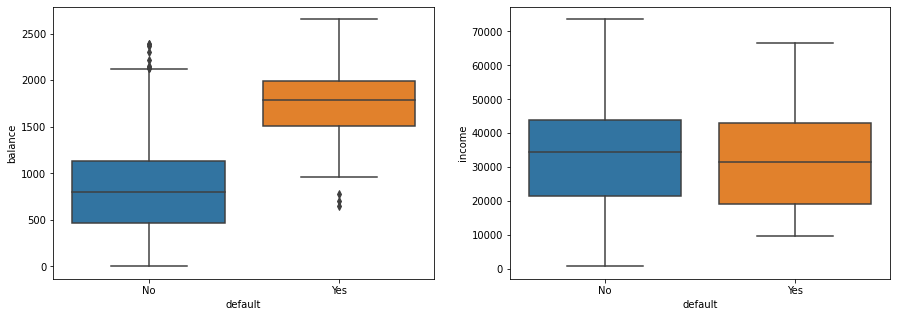

In [13]:
# Bivarite Analysis default VS other variables

plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
sns.boxplot(data.default, data.balance)

plt.subplot(1,2,2)
sns.boxplot(data.default, data.income)

plt.show();

We can see that people with balance outstanding 1500-2000 are defaulters.

In [20]:
# Lets create a crosstab with student and defaulters

pd.crosstab(data.student, data.default, normalize = "index").round(2)

default,No,Yes
student,,
No,0.97,0.03
Yes,0.96,0.04


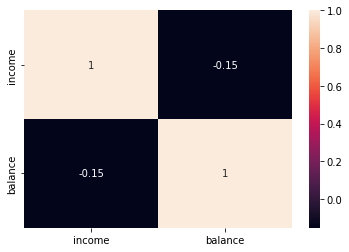

In [23]:
# Lets check for correlation with the numerical varibales

sns.heatmap(data[["income", "balance"]].corr(), annot = True)
plt.show();

##### Feature Engineering

In [24]:
# Lets check for missing values

data.isnull().sum()

default    0
student    0
balance    0
income     0
dtype: int64

In [25]:
# Outliers treatment

Q1, Q3 = data["balance"].quantile([.25, .75])
IQR = Q3 - Q1
lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

In [27]:
# Lets count the number of customers above upper_limit

df = data[data["balance"] > upper_limit]
df.value_counts().sum()

31

In [28]:
# Lets check the percentage of customers out of this above upper_limit range who are defaulters

df["default"].value_counts(normalize = True)

Yes    0.83871
No     0.16129
Name: default, dtype: float64

Note: We have 31 outliers in total, of which 84%(approx 26 in number) are with a default status 1. As such we have only 333 default instances in our data therefore dropping these 26 i.e. 8% will not be a good option.

In [29]:
# Now we will assign a value of upper_limit for those customers who have balance outstanding greater than upper_limit

data["balance"] = np.where(data["balance"] > upper_limit, upper_limit, data["balance"])

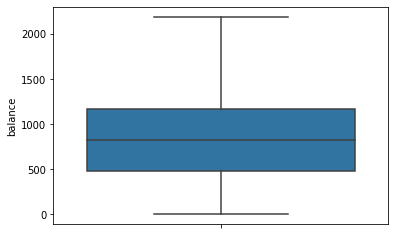

In [30]:
# Lets check the boxplot again

sns.boxplot(y = data.balance)
plt.show();

Outliers have been handled!

In [31]:
# Handling categorical variables

data = pd.get_dummies(data, drop_first = True)  # One Hot Encoding
data.head()

,balance,income,default_Yes,student_Yes
0,729.53,44361.63,0,0
1,817.18,12106.13,0,1
2,1073.55,31767.14,0,0
3,529.25,35704.49,0,0
4,785.66,38463.50,0,0


In [35]:
# Lets rename the columns

data.rename(columns = {"default_Yes" : "default", "student_Yes" : "student"}, inplace = True)
data.head()

,balance,income,default,student
0,729.53,44361.63,0,0
1,817.18,12106.13,0,1
2,1073.55,31767.14,0,0
3,529.25,35704.49,0,0
4,785.66,38463.50,0,0


In [36]:
# Independent and Dependent features

X = data.drop("default", axis = 1)
y = data["default"]

In [39]:
# Lets check the independent variables

X.head()

,balance,income,student
0,729.53,44361.63,0
1,817.18,12106.13,1
2,1073.55,31767.14,0
3,529.25,35704.49,0
4,785.66,38463.50,0


In [40]:
# Lets check the dependent variable

y.head()

0    0
1    0
2    0
3    0
4    0
Name: default, dtype: uint8

In [41]:
# Train test split

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 21, stratify = y)

Why stratify = y?
Please note, because this data is highly imbalanced and could possibly result into different proportions in the y variable between train and test set.

In [43]:
# Lets check whether it is evenly distributed or not

print(y_train.value_counts(normalize = True).round(2))

print(y_test.value_counts(normalize = True).round(2))

0    0.97
1    0.03
Name: default, dtype: float64
0    0.97
1    0.03
Name: default, dtype: float64


In [46]:
# As the dataset is highly imbalanced our ML model will give biasd results, so lets handle it by applyig SMOTE

from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 33, sampling_strategy = 0.75)
X_res, y_res = sm.fit_resample(X_train, y_train)

In [47]:
data_smote = pd.concat([X_res, y_res], axis = 1)

In [48]:
data.groupby("default").mean()

,balance,income,student
default,,,
0,803.870400,33566.166610,0.291404
1,1736.593536,32089.146847,0.381381


In [49]:
data_smote.groupby("default").mean()

,balance,income,student
default,,,
0,807.913022,33555.565605,0.288902
1,1748.067687,31074.712267,0.337537


#### Credit Risk Model Building

##### Model Building using Logistic Regression for 'Probability at default'

#### The equation of the Logistic Regression by which we predict the corresponding probabilities and then go on predict a discrete target variable is
#### y = $\frac{1}{1 + {e^{-z}}}$

##### Note: z  = $\beta_0$ +${\sum_{i=1}^{n}(\beta_i  X_1)}$

Let's first buld the model manually without using sklearn. Now, Importing statsmodels modules.

In [51]:
import statsmodels.formula.api as SM

##### Creating logistic regression equation & storing it in f_1

model = SM.logit(formula=’Dependent Variable ~ Σ𝐼𝑛𝑑𝑒𝑝𝑒𝑛𝑑𝑒𝑛𝑡 𝑉𝑎𝑟𝑖𝑎𝑏𝑙𝑒𝑠 (𝑘)’
               data = ‘Data Frame containing the required values’).fit()

In [54]:
# Lets create the train and test dataframes first

train = pd.concat([X_train, y_train], axis = 1)
train_smote = pd.concat([X_res, y_res ], axis = 1)
test = pd.concat([X_test, y_test], axis = 1)

In [55]:
# Lets set the formula

f_1 = 'default ~ student + balance + income'

In [56]:
# Lets fit the logistic regression model first on the old dataset(without SMOTE)

model_1 = SM.logit(formula = f_1, data = train).fit()

Optimization terminated successfully.
         Current function value: 0.078006
         Iterations 10


In [57]:
# Lets check the parameters

model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                default   No. Observations:                 7000
Model:                          Logit   Df Residuals:                     6996
Method:                           MLE   Df Model:                            3
Date:                Mon, 06 Sep 2021   Pseudo R-squ.:                  0.4657
Time:                        01:57:19   Log-Likelihood:                -546.04
converged:                       True   LL-Null:                       -1021.9
Covariance Type:            nonrobust   LLR p-value:                5.419e-206
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -10.4580      0.578    -18.080      0.000     -11.592      -9.324
student       -1.0130      0.282     -3.592      0.000      -1.566      -0.460
balance        0.0059      0.000     20.744      0.000       0.005       0.006
income      -1.53e-05   9.98e-06     -1.534      0.125   -3.49e-05    4.25e-06
==============================================================================

Possibly complete quasi-separation: A fraction 0.16 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

In [59]:
# Lets validate on the trainset

y_pred_train = np.where(model_1.predict(train) > 0.5, 1, 0)

from sklearn.metrics import confusion_matrix, classification_report

print(confusion_matrix(y_train, y_pred_train))

print(classification_report(y_train, y_pred_train))

[[6737   30]
 [ 158   75]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      6767
           1       0.71      0.32      0.44       233

    accuracy                           0.97      7000
   macro avg       0.85      0.66      0.72      7000
weighted avg       0.97      0.97      0.97      7000



In [61]:
# Lets validate on the test dataset

y_pred_test = np.where(model_1.predict(test) > 0.5, 1, 0)

print(confusion_matrix(y_test, y_pred_test))

print(classification_report(y_test, y_pred_test))

[[2888   12]
 [  66   34]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2900
           1       0.74      0.34      0.47       100

    accuracy                           0.97      3000
   macro avg       0.86      0.67      0.73      3000
weighted avg       0.97      0.97      0.97      3000



Model is not overfitting but the recall is really poor.

In [62]:
# Lets fit the logistic regression model on balanced data(with SMOTE)

model_2 = SM.logit(formula = f_1, data = train_smote).fit()

Optimization terminated successfully.
         Current function value: 0.236659
         Iterations 8


In [63]:
# Lets check the parameters

model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                default   No. Observations:                11842
Model:                          Logit   Df Residuals:                    11838
Method:                           MLE   Df Model:                            3
Date:                Mon, 06 Sep 2021   Pseudo R-squ.:                  0.6535
Time:                        02:09:01   Log-Likelihood:                -2802.5
converged:                       True   LL-Null:                       -8087.0
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -8.6320      0.240    -35.967      0.000      -9.102      -8.162
student       -1.7174      0.120    -14.283      0.000      -1.953      -1.482
balance        0.0072      0.000     51.698      0.000       0.007       0.007
income      -2.84e-05   4.09e-06     -6.935      0.000   -3.64e-05   -2.04e-05
==============================================================================
"""

In [67]:
# Validating on train set

y_pred_train_smote = np.where(model_2.predict(train_smote) > 0.5, 1, 0)

print(confusion_matrix(y_res, y_pred_train_smote))

print(classification_report(y_res, y_pred_train_smote))
                              
                              

[[6111  656]
 [ 500 4575]]
              precision    recall  f1-score   support

           0       0.92      0.90      0.91      6767
           1       0.87      0.90      0.89      5075

    accuracy                           0.90     11842
   macro avg       0.90      0.90      0.90     11842
weighted avg       0.90      0.90      0.90     11842



In [69]:
# Validating on the test set

y_pred_test_smote = np.where(model_2.predict(test) > 0.5, 1, 0)

print(confusion_matrix(y_test, y_pred_test_smote))

print(classification_report(y_test, y_pred_test_smote))

[[2634  266]
 [  18   82]]
              precision    recall  f1-score   support

           0       0.99      0.91      0.95      2900
           1       0.24      0.82      0.37       100

    accuracy                           0.91      3000
   macro avg       0.61      0.86      0.66      3000
weighted avg       0.97      0.91      0.93      3000



#### Conclusion
We can see that we get better recall value after balancing the data but precision is now a problem. This trade-off between recall and precision can be approached by adjusting the threshold. Note that at present we are using a threshold of 0.5.


In [71]:
# Now, lets build the same model using sklearn

# Lets import the sklearn logistic regression
from sklearn.linear_model import LogisticRegression

# Initializing an object
lr = LogisticRegression()

# Lets fit the model with the balanced dataset
lr_model = lr.fit(X_res, y_res)

# Lets validate the model on the test data
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Lets make the predictions
y_pred = lr_model.predict(X_test)

# Lets print the metrices
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.888
[[2589  311]
 [  25   75]]
              precision    recall  f1-score   support

           0       0.99      0.89      0.94      2900
           1       0.19      0.75      0.31       100

    accuracy                           0.89      3000
   macro avg       0.59      0.82      0.62      3000
weighted avg       0.96      0.89      0.92      3000

